In [13]:
using Pkg
include("/cluster/home/danare/git/Clustering/TSClustering.jl")
cd("/cluster/home/danare/git/Clustering")
Pkg.activate(".")
using .TSClustering
using Distances
using Clustering
using DelimitedFiles
using DataFrames
using DynamicAxisWarping
using Dates
using Statistics
using JuMP
using XLSX

  Activating project at `~/git/Clustering`


In [14]:
#### info: script to compare warping window size on chronology
# config
path = "/cluster/home/danare/git/GENeSYS_MOD.data/Output/output_excel/Timeseries_Europe_openENTRANCE_technoFriendly.xlsx"
config =  "/cluster/home/danare/git/Clustering/data/config5.yml"
path_genesys = "/cluster/home/danare/git/GENeSYS_MOD.data/Output/output_excel/input_reduced_timeserie_minimal_61.xlsx"
k = 20
technology = ["TS_LOAD", "TS_WIND_ONSHORE_AVG", "TS_WIND_OFFSHORE_DEEP", "TS_PV_AVG"]
region = "DE"
warping_window = Dict(
    "DTW (5)"  => 5,
);
total_ts = true

true

In [15]:
keys_mapping = Dict(
    "Power" => "TS_LOAD",
    "RES_PV_Utility_Avg" => "TS_PV_AVG",
    "RES_PV_Utility_Inf" => "TS_PV_INF",
    "RES_PV_Utility_Opt" => "TS_PV_OPT",
    "RES_PV_Utility_Tracking" => "TS_PV_TRA",
    "RES_Wind_Onshore_Avg" => "TS_WIND_ONSHORE_AVG",
    "RES_Wind_Onshore_Inf" => "TS_WIND_ONSHORE_INF",
    "RES_Wind_Onshore_Opt" => "TS_WIND_ONSHORE_OPT",
    "RES_Wind_Offshore_Transitional" => "TS_WIND_OFFSHORE",
    "RES_Wind_Offshore_Deep" => "TS_WIND_OFFSHORE_DEEP",
    "RES_Wind_Offshore_Shallow" => "TS_WIND_OFFSHORE_SHALLOW",
    "Heat_Low_Residential" => "TS_HEAT_LOW",
    "Heat_Medium_Industrial" => "TS_HEAT_HIGH",
    "HLR_Heatpump_Aerial" => "TS_HP_AIRSOURCE",
    "HLR_Heatpump_Ground" => "TS_HP_GROUNDSOURCE",
    "Mobility_Passenger" => "TS_MOBILITY_PSNG",
    "Mobility_Freight"=> "TS_MOBILITY_FRGT",
    "Heat_Low_Industrial"=> "TS_HEAT_LOW_IND",
    "Heat_High_Industrial"=> "TS_HEAT_HIGH_IND",
    "RES_Hydro_Small" => "TS_HYDRO_ROR",
);

In [16]:
config = TSClustering.read_yaml_file(file=config);

In [17]:
function convert_genesys_data(path_genesys, config, keys_mapping)
    demand = DataFrame(XLSX.readtable(path_genesys, "SpecifiedDemandProfile"));
    capacity_factor = DataFrame(XLSX.readtable(path_genesys, "CapacityFactor"));
    rename!(demand, :Fuel => :Technology);
    # define empty box
    genesys_data = JuMP.Containers.DenseAxisArray(zeros(length(config["countries"]), length(config["Country_Data_Entries"]),8760), config["countries"], config["Country_Data_Entries"], 1:8760)
    # merge both dfs 
    merged_df = vcat(demand, capacity_factor)
    merged_df[!,"Technology"] = [keys_mapping[item] for item in merged_df[!,"Technology"]]
    for t ∈ config["Country_Data_Entries"]
        println(t)
        filtered_df = filter(row -> (row.Technology == t && row.Region == region && row.Year == 2018), merged_df)
        weight = round(ceil(8760/length(unique(merged_df[!, "Timeslice"]))))
        z = Matrix(repeat(select(filtered_df, [:Value]), inner=Int(weight)))
        # adjust Load
        if t ∈ config["Load"]
            z = z /sum(z)
        end
        for j in 1:8760
            genesys_data[region, t,j] = z[j]
        end
    end
    return genesys_data
end

convert_genesys_data (generic function with 1 method)

In [18]:
genesys = convert_genesys_data(path_genesys, config, keys_mapping);

TS_LOAD
TS_PV_AVG
TS_WIND_ONSHORE_AVG
TS_WIND_OFFSHORE_DEEP


In [19]:
# read in data
data_org = TSClustering.read_data(path=path, config=config);
data_clustering_org = TSClustering.create_clustering_matrix(config=config, CountryData=data_org);
# apply normalization
data = TSClustering.normalize_data(CountryData=data_org, config=config);
data_clustering = TSClustering.create_clustering_matrix(config=config, CountryData=data);

p = collect(keys(warping_window))
append!(p, ["Original_Data"])

# define empty array
data_array = JuMP.Containers.DenseAxisArray(zeros(length(p),length(config["Country_Data_Entries"]),8760), p, config["Country_Data_Entries"], 1:8760) 

# add the remaining data
for (j, w) in enumerate(keys(warping_window))
    # define distance matrix
    D = TSClustering.define_distance(w=warping_window[w], data_clustering=data_clustering, fast_dtw=false)
    result = hclust(D, linkage=:ward)
    cl = cutree(result, k=k)
    weights = Dict{Int64, Int64}()
    for i in cl
        weights[i] = get(weights, i, 0) + 1
    end

    # bring data in Jump format
    m_cluster_org = TSClustering.calculate_representative(representative=:medoid, data_clustering=data_clustering_org, cl=cl, weights=weights, k=k);
    cluster_dict_org = TSClustering.convert_data(k=k, config=config, M=m_cluster_org);
    data_org = TSClustering.read_data(path=path, config=config);
    sc = TSClustering.scaling(data_org=data_org, scaled_clusters=cluster_dict_org, k=k, weights=weights, config=config)

    for t ∈ config["Country_Data_Entries"]
        data_array[w,t,:] = TSClustering.upsample_time_series(weight=weights, cluster_dict=sc, technology=t, region=region, config=config, tot_sum=true)
    end
end

# add original data
data_org_n = TSClustering.read_data(path=path, config=config);

for t ∈ config["Country_Data_Entries"]
    data_array["Original_Data",t,:] = data_org_n[t][:,region]
end

# create copy and sort
data_array_sorted = deepcopy(data_array)
for t ∈ axes(data_array_sorted)[2], s ∈ axes(data_array_sorted)[1]
    data_array_sorted[s,t,:] = sort(Vector(data_array_sorted[s, t, :]), rev=true)
end

TS_LOAD
TS_PV_AVG
TS_WIND_ONSHORE_AVG
TS_WIND_OFFSHORE_DEEP


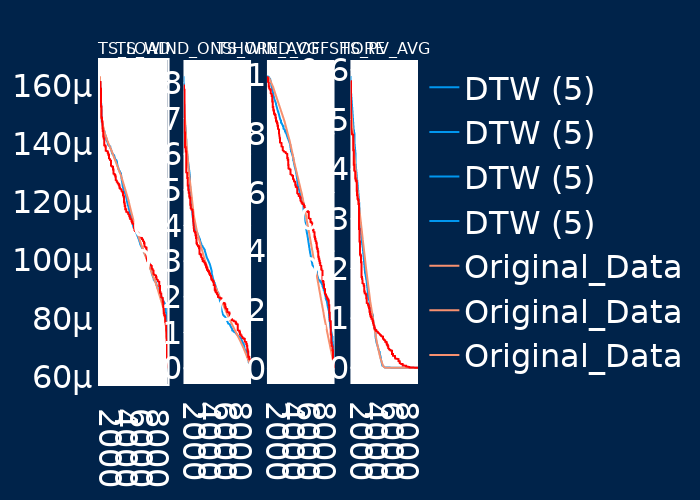

In [20]:
genesys = convert_genesys_data(path_genesys, config, keys_mapping);
TSClustering.plot_duration_curve(list_data=data_array_sorted, technology=technology,genesys=genesys, write_html=true)

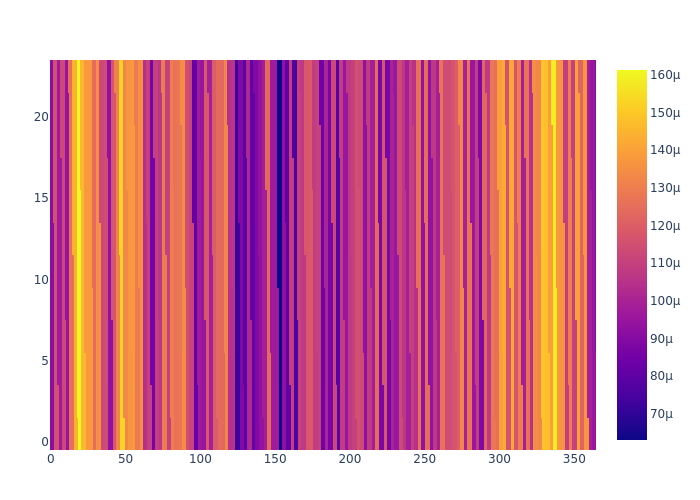

In [21]:
w = genesys["DE","TS_LOAD",:]
z = reshape(w, 24, 365)
TSClustering.plot_basic_heatmap(matrix=z)

In [22]:
w = data_array["DTW (10)", "TS_LOAD", :]
z = reshape(w, 24, 365)
TSClustering.plot_basic_heatmap(matrix=z)

KeyError: KeyError: key "DTW (10)" not found

In [23]:
w = data_array["Euclidean", "TS_LOAD", :]
z = reshape(w, 24, 365)
TSClustering.plot_basic_heatmap(matrix=z)

KeyError: KeyError: key "Euclidean" not found